In [1]:
from datetime import datetime
print("Current Date/Time: ", datetime.now())


Current Date/Time:  2020-09-26 22:15:39.684614


### **Import libraries and the common module**



In [2]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
#from torchvision import transforms

In [3]:
!pip install git+https://github.com/smitasasindran/eva5utils.git


  Cloning https://github.com/smitasasindran/eva5utils.git to /tmp/pip-req-build-91sin24x
  Running command git clone -q https://github.com/smitasasindran/eva5utils.git /tmp/pip-req-build-91sin24x
  Created wheel for eva5utils: filename=eva5utils-0.1.0-cp36-none-any.whl size=12355 sha256=dfafee7ec641d678d34790b4679f91274e8a8ff77fc2964f317c334d44ac0416
  Stored in directory: /tmp/pip-ephem-wheel-cache-iqqh5w6b/wheels/c6/bb/ac/e3952b213bfdb25cb23715782e1a6b4b4b5cb10e42a2b80aa9
Successfully built eva5utils


In [4]:
# Imports from common module

from eva5utils.dataloaders import load_cifar10
from eva5utils.model import Model7, ResNet18
from eva5utils.transforms import model9_resnet_train_transforms, model9_resnet_test_transforms
from eva5utils.train import train_loop
from eva5utils.test import test_loop
from eva5utils.utils import plot_samples
from eva5utils.utils.helpers import show_model_summary, DEVICE, IS_CUDA, accuracy_per_class, show_gradcam

### **QuizDNN**


    x1 = Input
    x2 = Conv(x1)
    x3 = Conv(x1 + x2)
    x4 = MaxPooling(x1 + x2 + x3)
    x5 = Conv(x4)
    x6 = Conv(x4 + x5)
    x7 = Conv(x4 + x5 + x6)
    x8 = MaxPooling(x5 + x6 + x7)
    x9 = Conv(x8)
    x10 = Conv (x8 + x9)
    x11 = Conv (x8 + x9 + x10)
    x12 = GAP(x11)
    x13 = FC(x12)


In [5]:
#dropout_value = 0.1

class QuizDNN(nn.Module):
  def __init__(self):
    super(QuizDNN, self).__init__()
  
    # x1 = Input      in_channels=3
    # x2 = Conv(x1)   in_channels=3, out=10
    self.x2 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(10),
        #nn.Dropout(dropout_value)
    ) # output_size = 30 .. should be 32

    #x3 = Conv(x1 + x2)       , in_channels=13,   x3_out=10
    self.x3 = nn.Sequential(
        nn.Conv2d(in_channels=13, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(10),
        #nn.Dropout(dropout_value)
    ) # output_size=30

    # x4 = MaxPooling(x1 + x2 + x3)   in_channels=3 + 10 + 10, x4_out = 3+10+10 = 23
    self.x4 = nn.MaxPool2d(2, 2) # output_size = 15

    # x5 = Conv(x4)                   in_channels=23, x5_out=10 
    self.x5 = nn.Sequential(
        nn.Conv2d(in_channels=23, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
        nn.ReLU(),            
        nn.BatchNorm2d(10),
        #nn.Dropout(dropout_value)
    ) # output_size = 

    # x6 = Conv(x4 + x5),     in=23 + 10, x6_out=10 
    self.x6 = nn.Sequential(
        nn.Conv2d(in_channels=33, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
        nn.ReLU(),            
        nn.BatchNorm2d(10),
        #nn.Dropout(dropout_value)
    ) # output_size = 

    # x7 = Conv(x4 + x5 + x6), in=23 + 10 + 10, out=10
    self.x7 = nn.Sequential(
        nn.Conv2d(in_channels=43, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
        nn.ReLU(),            
        nn.BatchNorm2d(10),
        #nn.Dropout(dropout_value)
    ) # output_size = 

    # x8 = MaxPooling(x5 + x6 + x7)   , in=10+10+10, out=30
    self.x8 = nn.MaxPool2d(2, 2) # output_size = 

    # x9 = Conv(x8)     , in=30, out=10
    self.x9 = nn.Sequential(
        nn.Conv2d(in_channels=30, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
        nn.ReLU(),            
        nn.BatchNorm2d(10),
        #nn.Dropout(dropout_value)
    ) # output_size = 

    # x10 = Conv (x8 + x9),     in=30+10, out=10
    self.x10 = nn.Sequential(
        nn.Conv2d(in_channels=40, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
        nn.ReLU(),            
        nn.BatchNorm2d(10),
        #nn.Dropout(dropout_value)
    ) # output_size = 

    # x11 = Conv (x8 + x9 + x10), in=30+10+10, out=30
    self.x11 = nn.Sequential(
        nn.Conv2d(in_channels=50, out_channels=30, kernel_size=(3, 3), padding=1, bias=False),
        nn.ReLU(),            
        nn.BatchNorm2d(30),
        #nn.Dropout(dropout_value)
    ) # output_size = 

    # x12 = GAP(x11)  # in=30, out=30
    self.x12 = nn.Sequential(
        nn.AvgPool2d(kernel_size=7)
    ) # output_size = 

    # # x13 = FC(x12), in=30, out=10
    self.x13 = nn.Linear(30, 10)
    
    self.x13_temp = nn.Sequential(
      nn.Conv2d(in_channels=30, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
    ) 


  def forward(self, x1):
    x2 = self.x2(x1)
    x3 = self.x3(torch.cat((x1, x2), dim=1))
    x4 = self.x4(torch.cat((x1, x3, x3), dim=1))
    x5 = self.x5(x4)
    x6 = self.x6(torch.cat((x4, x5), dim=1))
    x7 = self.x7(torch.cat((x4, x5, x6), dim=1))
    x8 = self.x8(torch.cat((x5, x6, x7), dim=1))
    x9 = self.x9(x8)
    x10 = self.x10(torch.cat((x8, x9), dim=1))
    x11 = self.x11(torch.cat((x8, x9, x10), dim=1))

    x12 = self.x12(x11)   # GAP layer
    #print("x12=", x12.shape)

    x13 = self.x13_temp(x12)
    #x13 = self.x13(x12)  # UNCOMMENT!!

    xf = x13.view(-1, 10)
    return xf


### **Check Model Summary**

In [6]:

model = QuizDNN()
show_model_summary(model.to(DEVICE), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 32, 32]             270
              ReLU-2           [-1, 10, 32, 32]               0
       BatchNorm2d-3           [-1, 10, 32, 32]              20
            Conv2d-4           [-1, 10, 32, 32]           1,170
              ReLU-5           [-1, 10, 32, 32]               0
       BatchNorm2d-6           [-1, 10, 32, 32]              20
         MaxPool2d-7           [-1, 23, 16, 16]               0
            Conv2d-8           [-1, 10, 16, 16]           2,070
              ReLU-9           [-1, 10, 16, 16]               0
      BatchNorm2d-10           [-1, 10, 16, 16]              20
           Conv2d-11           [-1, 10, 16, 16]           2,970
             ReLU-12           [-1, 10, 16, 16]               0
      BatchNorm2d-13           [-1, 10, 16, 16]              20
           Conv2d-14           [-1, 10,

### **Load the datasets**

Files already downloaded and verified
Files already downloaded and verified


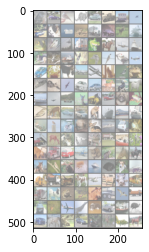

In [7]:
# Constants:

epochs = 40
cuda_batch_size=128
cpu_batch_size = 4
num_workers = 4

(trainloader, testloader, classes) = load_cifar10(model9_resnet_train_transforms(), model9_resnet_test_transforms(), cuda_batch_size, cpu_batch_size, num_workers)
plot_samples(trainloader)

### **Training  loop**

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=30, gamma=.1)
train_loop(epochs, trainloader, model, DEVICE, optimizer, criterion, scheduler)

[1,   391] loss: 579.104
[2,   391] loss: 421.252
[3,   391] loss: 356.134
[4,   391] loss: 324.236
[5,   391] loss: 304.097
[6,   391] loss: 287.461
[7,   391] loss: 276.813
[8,   391] loss: 269.029
[9,   391] loss: 260.437
[10,   391] loss: 254.792
[11,   391] loss: 248.656
[12,   391] loss: 244.051
[13,   391] loss: 239.614
[14,   391] loss: 236.674
[15,   391] loss: 234.192
[16,   391] loss: 228.212
[17,   391] loss: 224.880
[18,   391] loss: 223.136
[19,   391] loss: 220.232
[20,   391] loss: 216.219
[21,   391] loss: 216.083
[22,   391] loss: 212.817
[23,   391] loss: 209.841
[24,   391] loss: 210.242
[25,   391] loss: 208.103
[26,   391] loss: 206.430
[27,   391] loss: 204.632
[28,   391] loss: 203.761
[29,   391] loss: 200.972
[30,   391] loss: 200.652
[31,   391] loss: 181.327
[32,   391] loss: 174.233
[33,   391] loss: 173.969
[34,   391] loss: 172.355
[35,   391] loss: 171.985
[36,   391] loss: 171.413
[37,   391] loss: 169.156
[38,   391] loss: 170.768
[39,   391] loss: 170

### **Test Loop**

In [9]:
test_loop(testloader, model, DEVICE, criterion)
accuracy_per_class(model, classes, testloader, DEVICE)

Accuracy of the network on the 10000 test images: 78 %, Test loss: 2133.6524550914764
Accuracy of plane : 75 %
Accuracy of   car : 93 %
Accuracy of  bird : 72 %
Accuracy of   cat : 48 %
Accuracy of  deer : 77 %
Accuracy of   dog : 90 %
Accuracy of  frog : 87 %
Accuracy of horse : 80 %
Accuracy of  ship : 93 %
Accuracy of truck : 82 %


In [10]:
print("Current Date/Time: ", datetime.now())


Current Date/Time:  2020-09-26 22:24:31.611333
